# Ungraded Lab - Vector Embeddings in RAG

---

In this ungraded lab, you will explore vector embeddings using an embedding model. You will learn:

- How to use vector embeddings to find and understand contextual information.
- The basics of cosine similarity and Euclidean distance for comparing embeddings.
- Practical implementation of embeddings with a transformer-based model.
- Visualization of high-dimensional embeddings using PCA.


# Table of Contents
- [ 1 - Introduction](#1)
  - [ 1.1 A Bit of Theory](#1-1)
  - [ 1.2 The framework:](#1-2)
- [ 2 - The Embedding Model](#2)
  - [ 2.1 Introduction](#2-1)
  - [ 2.2 Loading the model](#2-2)
  - [ 2.3 Embeddings in Practice](#2-3)
  - [ 2.4 Visualizing Word Embeddings](#2-4)
- [ 3 - Embeddings and Input Size](#3)
  - [ 3.1 An Example](#3-1)


---
<h4 style="color:black; font-weight:bold;">USING THE TABLE OF CONTENTS</h4>

JupyterLab provides an easy way for you to navigate through your assignment. It's located under the Table of Contents tab, found in the left panel, as shown in the picture below.

![TOC Location](images/toc.png)

<a id='1'></a>
## 1 - Introduction

---

In the context of RAG, vector embeddings are used for: 

1. **Powering Search:**
   - **Capturing Meaning:** Vector embeddings act like a map for text. They convert words and sentences into positions in vector space that capture meaning. These vectors can then be used to locate information matching a query.
   - **Comparing Similarity:** When a prompt is received, it is converted into an embedding vector of its own. Then, the similarity between this prompt's vector and other vectors in the database can be calculated. This helps identify texts closest in meaning to the prompt.

2. **Understanding Context:**
   - **Context Matters:** They help in understanding the context of words in a query, ensuring that the best-matched information is found.
   - **Flexibility:** Contextual embeddings allow for adapting to different meanings and capturing details that might otherwise be overlooked.

In essence, vector embeddings are a behind-the-scenes technology that facilitates smarter, more helpful, and accurate data retrieval by capturing nuances in a way that no other search technique provides.

<a id='1-1'></a>
### 1.1 A Bit of Theory


In vector retrieval, you use an embedding model to convert prompts and documents into vectors. To find the most relevant documents for a query, you check their similarity using distance measures:

1. **Cosine Similarity**: This evaluates how close two vectors are based on their angle. For a query vector $ \mathbf{q} $ and a document vector $ \mathbf{d}_i $:

<div style="text-align: center;">
  <img src="images/cosine.png" alt="Description" style="width: 300px;">
</div>

   $$
   \text{Cosine Similarity}(\mathbf{q}, \mathbf{d}_i) = \frac{\mathbf{q} \cdot \mathbf{d}_i}{\|\mathbf{q}\| \|\mathbf{d}_i\|}
   $$

   A value close to 1 indicates that the vectors, and thus the texts, are very similar.

2. **Euclidean Distance**: This calculates the "straight-line" distance between two vectors in the embedding space:

<div style="text-align: center;">
  <img src="images/euclidean.png" alt="Description" style="width: 300px;">
</div>

   $$
   \text{Euclidean Distance}(\mathbf{q}, \mathbf{d}_i) = \sqrt{\sum_{j=1}^{n}(q_j - d_{ij})^2}
   $$

   Smaller distances suggest more closely related content.

<a id='1-2'></a>
### 1.2 The framework:

1. **Create the embedding**: Use an embedding method to convert your query and documents into vectors.
2. **Metric measurement**: Use a similarity metric to determine how close each document is to your query.
3. **Sorting**: Sort the documents by their similarity score and select the top few as the most relevant. Be mindful that for some metrics, a higher score indicates greater similarity between two vectors (as with cosine similarity), while for others, a lower score indicates greater similarity (as with Euclidean distance).

---
<div style="text-align: center;">
  <img src="images/documents.png" alt="Description" style="width: 80%;">
</div>

This gives us an easy way to query a database!

Let's explore!

In [1]:
import numpy as np
import os
from utils import (
    display_widget,
    plot_vectors
)

In [2]:
# Distance formulas. 
# In this ungraded lab, distance formulas are implemented here. In future assignments, you will import functions from specialized libraries.
def cosine_similarity(v1, array_of_vectors):
    """
    Compute the cosine similarity between a vector and an array of vectors.
    
    Parameters:
    v1 (array-like): The first vector.
    array_of_vectors (array-like): An array of vectors or a single vector.

    Returns:
    list: A list of cosine similarities between v1 and each vector in array_of_vectors.
    """
    # Ensure that v1 is a numpy array
    v1 = np.array(v1)
    # Initialize a list to store similarities
    similarities = []
    
    # Check if array_of_vectors is a single vector
    if len(np.shape(array_of_vectors)) == 1:
        array_of_vectors = [array_of_vectors]
    
    # Iterate over each vector in the array
    for v2 in array_of_vectors:
        # Convert the current vector to a numpy array
        v2 = np.array(v2)
        # Compute the dot product of v1 and v2
        dot_product = np.dot(v1, v2)
        # Compute the norms of the vectors
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        # Compute the cosine similarity and append to the list
        similarity = dot_product / (norm_v1 * norm_v2)
        similarities.append(similarity)
    return [float(x) for x in similarities]

def euclidean_distance(v1, array_of_vectors):
    """
    Compute the Euclidean distance between a vector and an array of vectors.
    
    Parameters:
    v1 (array-like): The first vector.
    array_of_vectors (array-like): An array of vectors or a single vector.

    Returns:
    list: A list of Euclidean distances between v1 and each vector in array_of_vectors.
    """
    # Ensure that v1 is a numpy array
    v1 = np.array(v1)
    # Initialize a list to store distances
    distances = []
    
    # Check if array_of_vectors is a single vector
    if len(np.shape(array_of_vectors)) == 1:
        array_of_vectors = [array_of_vectors]
    
    # Iterate over each vector in the array
    for v2 in array_of_vectors:
        # Convert the current vector to a numpy array
        v2 = np.array(v2)
        # Check if the input arrays have the same shape
        if v1.shape != v2.shape:
            raise ValueError(f"Shapes don't match: v1 shape: {v1.shape}, v2 shape: {v2.shape}")
        # Calculate the Euclidean distance and append to the list
        dist = np.sqrt(np.sum((v1 - v2) ** 2))
        distances.append(dist)
    return [float(x) for x in distances]

In [3]:
# Example 
v1 = [1, 2]
v2 = [1, 1]
array_v = [[3, 2], [5, 6]]
cosine_v1_v2 = cosine_similarity(v1, v2)
cosine_v1_array_v = cosine_similarity(v1, array_v)
euclidean_v1_v2 = euclidean_distance(v1, v2)
euclidean_v1_array_v = euclidean_distance(v1, array_v)
print(f"Cosine Similarity between v1 and v2: {cosine_v1_v2}")
print(f"Cosine Similarities between v1 and array_v: {cosine_v1_array_v}")
print(f"Euclidean Distance between v1 and v2: {euclidean_v1_v2}")
print(f"Euclidean Distances between v1 and array_v: {euclidean_v1_array_v}")

Cosine Similarity between v1 and v2: [0.9486832980505138]
Cosine Similarities between v1 and array_v: [0.8682431421244593, 0.973417168333576]
Euclidean Distance between v1 and v2: [1.0]
Euclidean Distances between v1 and array_v: [2.0, 5.656854249492381]


Notice that the output is always a `list`.

Observe the following: In terms of **cosine similarity**, the vector closest to v1 is the **second vector** in the array. However, when considering **Euclidean distance**, the closest vector is the **first vector**. This occurs because these metrics evaluate different attributes. Cosine similarity measures **the angle between two vectors**, while **Euclidean distance** measures the actual distance between them as we typically understand it. Consequently, with cosine similarity, the actual distances between the points forming the vectors are irrelevant. Let's plot them to investigate!

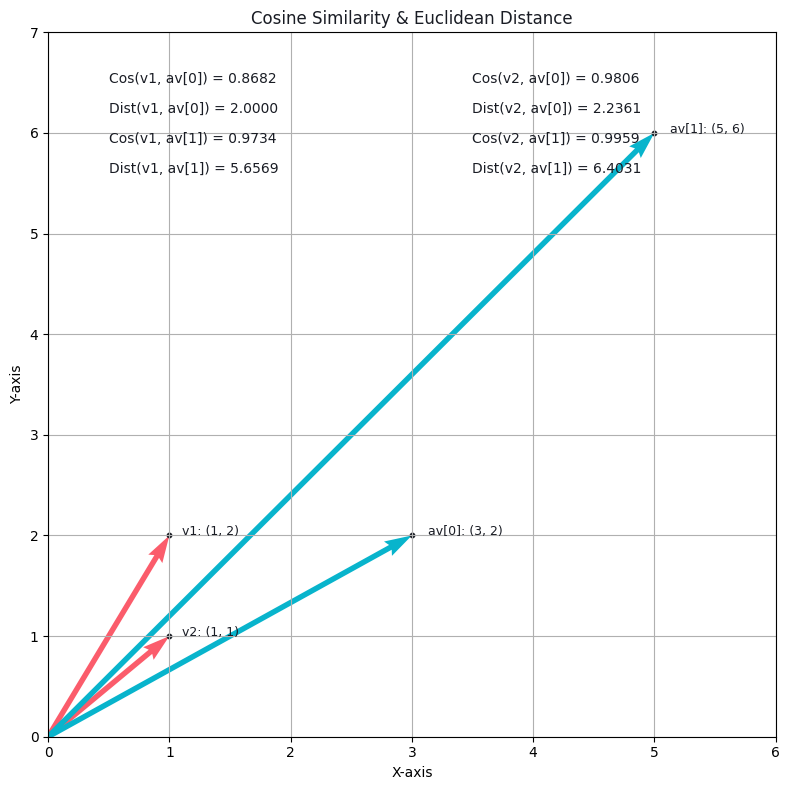

In [4]:
plot_vectors()

<a id='2'></a>
## 2 - The Embedding Model
---
<a id='2-1'></a>
### 2.1 Introduction

The embedding model is responsible for converting a word or sentence into a fixed-size vector. It is trained on millions of samples and is specialized in grouping semantically related sentences.

<div style="text-align: center;">
  <img src="images/embedding.png" alt="Description" style="width: 80%;">
</div>

<a id='2-2'></a>
### 2.2 Loading the model

Now, let's load the model to generate the embeddings. It is the [BAAI/bge-base-en-v1.5](https://huggingface.co/BAAI/bge-base-en-v1.5) model, a transformer-based model capable of embedding entire sentences. It generates an embedding with 768 dimensions. 

In [5]:
from sentence_transformers import SentenceTransformer

# Load the pre-trained sentence transformer model
model_name =  "BAAI/bge-base-en-v1.5"


model = SentenceTransformer(os.path.join(os.environ['MODELS'],model_name))

In [6]:
# To get a string embedded, just pass it to the model.
res = model.encode("RAG is awesome")
print(res.shape)

(768,)


In [7]:
# An array of strings can be passed, and the output will be an array of vectors, each with 768 dimensions.
model.encode(['apple', 'car'])

array([[-0.02102228,  0.06316223,  0.00100865, ..., -0.00027881,
         0.00038429, -0.0281808 ],
       [ 0.00472376,  0.01583517,  0.04418232, ..., -0.05767508,
         0.04269505, -0.00054617]], shape=(2, 768), dtype=float32)

In [8]:
# Print the first 100 elements of the embedding.
print(res[:100])

[ 0.00886302 -0.04775146 -0.00156089  0.01309993 -0.00206938 -0.06157268
  0.01384688  0.00101498 -0.04903949 -0.04762559 -0.03628184  0.00478035
 -0.03492182  0.05323148  0.02193964  0.03645132  0.04029363 -0.00453639
  0.01883798 -0.03367384  0.02516192 -0.04843621 -0.04047944  0.02590903
  0.02175229  0.03160364  0.03937921 -0.03640463 -0.03113303 -0.01247228
  0.03661649 -0.00458202 -0.00100169 -0.03188789  0.02957137  0.01986158
 -0.00737474  0.02370178 -0.02151621 -0.07361361 -0.01723555 -0.01986945
  0.0412974   0.00490013 -0.02677387  0.02022934  0.02961315  0.04925792
 -0.01277176 -0.0343213  -0.01399967  0.05282128 -0.00477824 -0.01757415
  0.02563439  0.01647311  0.02277317  0.0040155   0.01687664 -0.0270974
 -0.05021426  0.00170135  0.00196164 -0.0198381   0.01350141  0.03220811
 -0.02747846  0.00955025 -0.02966274 -0.03902559  0.03015532  0.01090192
 -0.06928955  0.00174676  0.0398838  -0.00745262  0.02402302 -0.00481087
  0.01576156  0.06735057  0.0020645  -0.02449706  0.

The sentence is converted into a point in a 768-dimensional vector space, where various metrics can be used to measure the distance between sentences or words. The idea is that closer vectors imply semantically similar sentences.

<a id='2-3'></a>
### 2.3 Embeddings in Practice

In this section, you will see why embeddings are useful and how they capture semantic information by comparing words/sentences using two metrics: Cosine Similarity and Euclidean Distance.

In [9]:
words = ['apple', 'car', 'fruit', 'automobile', 'love', 'sentiment']
vectorized_words = model.encode(words)

In [10]:
word = 'apple'
print(f"{word}:")
for i, w in enumerate(words):
    # Get the vectorized word for the word defined above
    vectorized_word = vectorized_words[words.index(word)]
    print(f"\t{w}:\t\tCosine Similarity: {cosine_similarity(vectorized_word, vectorized_words[i])[0]:.4f}")
print("\n\n\n")
for i, w in enumerate(words):
    # Get the vectorized word for the word defined above
    vectorized_word = vectorized_words[words.index(word)]
    print(f"\t{w}:\t\tEuclidean Distance: {euclidean_distance(vectorized_word, vectorized_words[i])[0]:.4f}")

apple:
	apple:		Cosine Similarity: 1.0000
	car:		Cosine Similarity: 0.5749
	fruit:		Cosine Similarity: 0.7461
	automobile:		Cosine Similarity: 0.6485
	love:		Cosine Similarity: 0.5540
	sentiment:		Cosine Similarity: 0.5020




	apple:		Euclidean Distance: 0.0000
	car:		Euclidean Distance: 0.9221
	fruit:		Euclidean Distance: 0.7126
	automobile:		Euclidean Distance: 0.8384
	love:		Euclidean Distance: 0.9445
	sentiment:		Euclidean Distance: 0.9980


Note that for cosine similarity, the closer to 1, the more similar two words are, whereas for Euclidean distance, similar words have a smaller distance! Now, given the words above, let's create a function to sort them by similarity.

In [11]:
def retrieve_relevant(query, documents, metric='cosine_similarity'):
    """
    Retrieves and ranks documents based on their similarity to a given query using the specified metric.
    
    Parameters:
    query (str): The query string for which relevant documents are to be retrieved.
    documents (list of str): A list of documents to be compared against the query.
    metric (str, optional): The similarity measurement metric to be used. It supports 'cosine_similarity'
                            and 'euclidean'. Defaults to 'cosine_similarity'.
    
    Returns:
    list of tuples: A list of tuples where each tuple contains a document and its similarity or distance
                    score with respect to the query. The list is sorted based on these scores, with
                    descending order for 'cosine_similarity' and ascending order for 'euclidean'.
    """
    query_emb = model.encode(query)
    documents_emb = model.encode(documents)
    vals = []

    if metric == 'cosine_similarity':
        distances = cosine_similarity(query_emb, documents_emb)
        vals = [(doc, dist) for doc, dist in zip(documents, distances)]
        # Sort in descending order
        vals.sort(reverse=True, key=lambda x: x[1])
        
    elif metric == 'euclidean':
        distances = euclidean_distance(query_emb, documents_emb)
        vals = [(doc, dist) for doc, dist in zip(documents, distances)]
        # Sort in ascending order
        vals.sort(key=lambda x: x[1])
        
    return vals

In [12]:
documents = [
    "Mt. Fuji is a breathtaking place to explore during autumn.",
    "Santorini offers stunning views to admire during spring.",
    "Banff National Park is a picturesque destination to visit in the summer.",
    "The Great Wall of China is a spectacular site to experience during winter.",
    "The fjords of Norway are a magical place to cruise through in the spring.",
    "Prague is an enchanting city to wander through in winter.",
    "Kyoto's cherry blossoms create a beautiful scene to witness during spring.",
    "Marrakech offers vibrant markets and culture to enjoy in the fall.",
    "The Maldives are a paradisiacal getaway to savor during summer.",
    "The Christmas markets in Vienna are a festive delight to explore in winter."
]

query = "Suggest to me great places to visit in Asia."
score = retrieve_relevant(query, documents, metric='cosine_similarity')
score

[('The Great Wall of China is a spectacular site to experience during winter.',
  0.6080514788627625),
 ('Mt. Fuji is a breathtaking place to explore during autumn.',
  0.5821483731269836),
 ('The Maldives are a paradisiacal getaway to savor during summer.',
  0.560464084148407),
 ('Santorini offers stunning views to admire during spring.',
  0.5512210726737976),
 ('Banff National Park is a picturesque destination to visit in the summer.',
  0.5220363140106201),
 ("Kyoto's cherry blossoms create a beautiful scene to witness during spring.",
  0.515005886554718),
 ('The fjords of Norway are a magical place to cruise through in the spring.',
  0.4847024977207184),
 ('The Christmas markets in Vienna are a festive delight to explore in winter.',
  0.47109079360961914),
 ('Marrakech offers vibrant markets and culture to enjoy in the fall.',
  0.4674411416053772),
 ('Prague is an enchanting city to wander through in winter.',
  0.4483718276023865)]

In [13]:
score = retrieve_relevant(query, documents, metric='euclidean')
score

[('The Great Wall of China is a spectacular site to experience during winter.',
  0.8853796720504761),
 ('Mt. Fuji is a breathtaking place to explore during autumn.',
  0.914168119430542),
 ('The Maldives are a paradisiacal getaway to savor during summer.',
  0.9375884532928467),
 ('Santorini offers stunning views to admire during spring.',
  0.9473953247070312),
 ('Banff National Park is a picturesque destination to visit in the summer.',
  0.9777155518531799),
 ("Kyoto's cherry blossoms create a beautiful scene to witness during spring.",
  0.9848798513412476),
 ('The fjords of Norway are a magical place to cruise through in the spring.',
  1.0151822566986084),
 ('The Christmas markets in Vienna are a festive delight to explore in winter.',
  1.0285030603408813),
 ('Marrakech offers vibrant markets and culture to enjoy in the fall.',
  1.0320454835891724),
 ('Prague is an enchanting city to wander through in winter.',
  1.0503602027893066)]

While one might expect **"Kyoto's cherry blossoms create a beautiful scene to witness during spring." to rank higher** given its relevance to the query, transformer embedding models capture similarity based on the **contexts in which words appear together** in the training data. Therefore, even though Kyoto is factually more relevant, the model may have learned **stronger associations between common travel-related sentences** (like "places to visit") and other destinations, like "Santorini" and "Banff," due to their **frequent co-occurrence in travel contexts during the training phase**. This results in their higher ranking, as the embedding model captures is trained to capture these relationships.

<a id='2-4'></a>
### 2.4 Visualizing Word Embeddings

As you have seen, embeddings are a way of turning sentences or words into high-dimensional vectors that capture semantic properties. By doing so, it's possible to apply linear algebra tools like distances to measure how close the points are, reflecting their semantic relations.

The embedding model you've worked with above embeds a sentence into a 768-dimensional vector, which is impossible to visualize in its entirety. In this section, you will visualize vector embeddings using a technique known as [PCA (Principal Component Analysis)](https://en.wikipedia.org/wiki/Principal_component_analysis), to reduce the dimensionality of these vectors to two, allowing us to visualize their distances.

In [14]:
display_widget(model)

<a id='3'></a>
## 3 - Embeddings and Input Size
---
In this section, we explore how the size of input text impacts the generation of vector embeddings. Vector embeddings capture the semantic essence of a text. However, there is a limit to how much text these models can process at once, leading to truncation of text that exceeds this limit. When truncation occurs, all information beyond a certain point in the text is lost, potentially impacting the effectiveness and accuracy of the embedding.

<a id='3-1'></a>
### 3.1 An Example
The example below illustrates how semantic meaning can be lost due to truncation. Any information beyond a certain point in the input text is not considered, leading to an incomplete representation in the embedding vector.

Let's load a large text.

In [15]:
big_text = open("large_text.txt").read()

In [16]:
len(big_text)

3955

In [17]:
# Entire text
big_text_embedding = model.encode(big_text)

# Text with fewer characters
big_text_embedding_few_characters = model.encode(big_text[:3000])

In [18]:
# Checking if they are the same
np.array_equal(big_text_embedding, big_text_embedding_few_characters)

True

Note that they are the **same** vector, not even a single element different. This is because the context window for this model is 512 tokens, so **anything** beyond that is completely ignored. In the next modules, you will learn ways to handle large texts!

Keep it up! You have finished the ungraded lab on how embeddings work!